# LAB 02:   Advanced Feature Engineering in BQML

**Learning Objectives**

* Perform a feature cross using BigQuery's ML.FEATURE_CROSS
* Derive a coordinate feature
* Feature cross coordinate features
* Code cleanup
* Apply the BUCKETIZE function
* Apply the TRANSFORM clause
* Apply L2 Regularization
* Evaluate model performance 
* Create a predictive model
* Create an RMSE Summary table



## Introduction 
In this lab, we continue to utilize feature engineering to improve the prediction of the fare amount for a taxi ride in New York City by reducing the RMSE.

In this Notebook, we perform a feature cross using BigQuery's ML.FEATURE_CROSS, derive coordinate features, feature cross coordinate features, cleanup the code, apply the BUCKETIZE function, the TRANSFORM clause, L2 Regularization, and evaluate model performance throughout the process.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solution/feateng-solution_bqml.ipynb). **NOTE TO SELF**:  UPDATE HYPERLINK. 


### Model 4:  Apply the ML.FEATURE_CROSS clause to categorical features

BigQuery ML now has ML.FEATURE_CROSS, a pre-processing clause that performs a feature cross.  

* ML.FEATURE_CROSS generates a [STRUCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types#struct-type) feature with all combinations of crossed categorical features, except for 1-degree items (the original features) and self-crossing items.  

* Syntax:  ML.FEATURE_CROSS(STRUCT(features), degree)

* The feature parameter is a categorical features separated by comma to be crossed. The maximum number of input features is 10. An unnamed feature is not allowed in features. Duplicates are not allowed in features.

* Degree(optional): The highest degree of all combinations. Degree should be in the range of [1, 4]. Default to 2.

Output: The function outputs a STRUCT of all combinations except for 1-degree items (the original features) and self-crossing items, with field names as concatenation of original feature names and values as the concatenation of the column string values.


#### Exercise:  The ML.Feature_Cross statement contains errors. Correct the errors and run the query.

In [ ]:
%%bigquery
#Objective:  Perform a feature cross using BigQuery's ML.FEATURE_CROSS
CREATE OR REPLACE MODEL feat_eng.model_4
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  ML.FEATURE_CROSS(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING),
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`


In [12]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_4
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
 ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`


""


#### Exercise:  Create two SQL statements to evaluate the model.

In [ ]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_4)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.500029,93.260577,0.27445,3.807548,0.080263,0.080492


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_4)

,rmse
0,9.657152


### Sliding down the slope toward a loss minimum (reduced taxi fare)!
* Our fourth model above gives us an RMSE of 9.65 for estimating fares. Recall our heuristic benchmark was 8.29. This may be the result of feature crossing.  Let's apply more feature engineering techniques to see if we can't get this loss metric lower!

### Model 5:  Feature cross coordinate features to create a Euclidean feature


Pickup coordinate:
*  pickup_longitude AS pickuplon
*  pickup_latitude AS pickuplat

Dropoff coordinate:
*   #dropoff_longitude AS dropofflon
*   #dropoff_latitude AS dropofflat

**Coordinate Features**:
* The pick-up and drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled.  As such, we need to  teach the model the Euclidean distance between the pick-up and drop-off points.  

* Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates.  In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York city has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

* The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordinate points.

* We need to convert those coordinates into a single column of a spatial data type.  We will use the ST_DISTANCE and the ST_GEOGPOINT functions.  

* ST_DISTANCE:  ST_DISTANCE(geography_1, geography_2).  Returns the shortest distance in meters between two non-empty GEOGRAPHYs (e.g. between two spatial objects).

* ST_GEOGPOINT:  ST_GEOGPOINT(longitude, latitude).  Creates a GEOGRAPHY with a single point. ST_GEOGPOINT creates a point from the specified FLOAT64 longitude and latitude parameters and returns that point in a GEOGRAPHY value.


#### Exercise:  Derive a coordinate feature.

* Convert the feature coordinates into a single column of a spatial data type. Use the The ST_Distance and the ST.GeogPoint functions.
SAMPLE CODE:
ST_Distance(ST_GeogPoint(value1,value2), ST_GeogPoint(value3, value4)) AS euclidean




In [ ]:
# TODO: Your code goes here
# Objective:  Derive a coordinate feature

In [13]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_5
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create two SQL statements to evaluate the model. 

In [ ]:
  # TODO: Your code goes here

In [ ]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_5)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,3.121311,31.229717,0.106923,2.218179,0.661492,0.661507


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_5)

,rmse
0,5.588356


### Model 6:  Feature cross  pick-up and drop-off locations features

In this section, we feature cross the pick-up and drop-off locations so that the model can learn pick-up-drop-off pairs that will require tolls.

This step takes the geographic point corresponding to the pickup point and grids to a 0.1-degree-latitude/longitude grid (approximately 8km x 11km in New York—we should experiment with finer resolution grids as well). Then, it concatenates the pickup and dropoff grid points to learn “corrections” beyond the Euclidean distance associated with pairs of pickup and dropoff locations.

Because the lat and lon by themselves don't have meaning, but only in conjunction, it may be useful to treat the fields as a pair instead of just using them as numeric values. However, lat and lon are continuous numbers, so we have to discretize them first. That's what SnapToGrid does. 


* ST_SNAPTOGRID:  ST_SNAPTOGRID(geography_expression, grid_size).  Returns the input GEOGRAPHY, where each vertex has been snapped to a longitude/latitude grid. The grid size is determined by the grid_size parameter which is given in degrees.

**REMINDER**: The ST_GEOGPOINT creates a GEOGRAPHY with a single point. ST_GEOGPOINT creates a point from the specified FLOAT64 longitude and latitude parameters and returns that point in a GEOGRAPHY value.  The ST_Distance function returns the minimum distance between two spatial objectsa.  It also returns meters for geographies and SRID units for geometrics.  

#### Excercise:  The following SQL statement is incorrect.  Modify the code to feature cross the pick-up and drop-off locations features. 

In [ ]:
%%bigquery
#Objective:  Feature cross coordinate features
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  #CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING), 
        #CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
 ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplat,pickuplon,pickuplat), 0.05)), 
 ST_AsText(ST_GeogPoint(dropofflon, dropofflat,dropofflon), 0.04)) AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`


In [14]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean,
   CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon, pickuplat), 0.01)),
     ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon, dropofflat), 0.01)))
  AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create two SQL statements to evaluate the model.

In [ ]:
%%bigquery
#SOLUTION
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_6)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.678752,34.885692,0.088598,1.485065,0.640979,0.642637


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_6)

,rmse
0,5.906411


### Code Clean Up

#### Exercise:  Clean up the code to see where we are

Remove all the commented statements in the SQL statement.  We should now have a total of five input features for our model.  
1. fare_amount
2. passengers
3. day_hr
4. euclidean
5. pickup_and_dropoff

In [ ]:
%%bigquery
#Objective:  Code Clean Up
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  #pickup_datetime,
  #EXTRACT(DAYOFWEEK FROM pickup_datetime) AS dayofweek,
  #EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  #pickuplon,
  #pickuplat,
  #dropofflon,
  #dropofflat,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean,
   CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon, pickuplat), 0.01)),
     ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon, dropofflat), 0.01)))
  AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

In [15]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_6
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) 
  AS euclidean,
  CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon, pickuplat), 0.01)),
     ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon, dropofflat), 0.01)))
  AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

""


## BQML's Pre-processing functions:

Here are some of the preprocessing functions in BigQuery ML:
* ML.FEATURE_CROSS(STRUCT(features))    does a feature cross of all the combinations
* ML.POLYNOMIAL_EXPAND(STRUCT(features), degree)    creates x, x^2, x^3, etc.
* ML.BUCKETIZE(f, split_points)   where split_points is an array 

### Model 7:  Apply the BUCKETIZE Function 


##### BUCKETIZE 
Bucketize is a pre-processing function that creates "buckets" (e.g bins) - e.g. it bucketizes a continuous numerical feature into a string feature with bucket names as the value.

* ML.BUCKETIZE(feature, split_points)

* feature: A numerical column.

* split_points: Array of numerical points to split the continuous values in feature into buckets. With n split points (s1, s2 … sn), there will be n+1 buckets generated. 

* Output: The function outputs a STRING for each row, which is the bucket name. bucket_name is in the format of bin_<bucket_number>, where bucket_number starts from 1.

* Currently, our model uses the ST_GeogPoint function to derive the pickup and dropoff feature.  In this lab, we use the BUCKETIZE function to create the pickup and dropoff feature.

#### Exercise: Apply the BUCKETIZE function.
* Hint:  Create a model_7.

In [ ]:
# TODO: Your code goes here
# Objective:  Apply the BUCKETIZE funcation

In [16]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.model_7
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) AS euclidean,
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
  
FROM `feat_eng.feateng_training_data`

""


#### Exercise:  Create three SQL statements to EVALUATE the model.

In [ ]:
%%bigquery
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.model_7)
#NOTE that with each iteration, loss decreases.

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,3,11.231835,33.172360,0.4,6434,3.351393
1,0,2,13.263899,35.919936,0.8,5898,3.641964
2,0,1,20.108475,36.559006,0.4,6533,4.484247
3,0,0,70.490524,81.719679,0.2,3746,8.395864


In [ ]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.model_7)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.674187,33.17236,0.089913,1.51821,0.635728,0.637299


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.model_7)

,rmse
0,5.759545


### Final Model:  Apply the TRANSFORM clause and L2 Regularization

Before we perform our prediction, we should encapsulate the entire feature set in a TRANSFORM clause.  BigQuery ML now supports defining data transformations during model creation, which will be automatically applied during prediction and evaluation. This is done through the TRANSFORM clause in the existing CREATE MODEL statement. By using the TRANSFORM clause, user specified transforms during training will be automatically applied during model serving (prediction, evaluation, etc.) 

In our case, we are using the TRANSFORM clause to separate out the raw input data from the TRANSFORMED features.  The input columns of the TRANSFORM clause is the query_expr (AS SELECT part).  The output columns of TRANSFORM from select_list are used in training. These transformed columns are post-processed with standardization for numerics and one-hot encoding for categorical variables by default. 

The advantage of encapsulating features in the TRANSFORM clause is the client code doing the PREDICT doesn't change, e.g. our model improvement is transparent to client code. Note that the TRANSFORM clause MUST be placed after the CREATE statement.

##### [L2 Regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization) 
Sometimes, the training RMSE is quite reasonable, but the evaluation RMSE illustrate more error. Given the severity of the delta between the EVALUATION RMSE and the TRAINING RMSE, it may be an indication of overfitting. When we do feature crosses, we run into the risk of overfitting (for example, when a particular day-hour combo doesn't have enough taxi rides).

Overfitting is a phenomenon that occurs when a machine learning or statistics model is tailored to a particular dataset and is unable to generalize to other datasets. This usually happens in complex models, like deep neural networks.  Regularization is a process of introducing additional information in order to prevent overfitting.

Therefore, we will apply L2 Regularization to the final model.  As a reminder, a regression model that uses the L1 regularization technique is called Lasso Regression while a regression model that uses the L2 Regularization technique is called Ridge Regression.  The key difference between these two is the penalty term.  Lasso shrinks the less important feature’s coefficient to zero, thus removing some features altogether.  Ridge regression adds “squared magnitude” of coefficient as a penalty term to the loss function.

In other words, L1 limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. 

L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). 

The regularization terms are ‘constraints’ by which an optimization algorithm must ‘adhere to’ when minimizing the loss function, apart from having to minimize the error between the true y and the predicted ŷ.  This in turn reduces model complexity, making our model simpler. A simpler model can reduce the chances of overfitting.

#### Exercise:  Apply the TRANSFORM clause and L2 Regularization to the final model and run the query.

In [ ]:
# TODO: Your code goes here
# Objective: Apply the TRANSFORM clause and L2 Regularization to the final model and run the query.

In [17]:
%%bigquery
#SOLUTION
CREATE OR REPLACE MODEL feat_eng.final_model
TRANSFORM(
  fare_amount, 
    #SQRT( (pickuplon-dropofflon)*(pickuplon-dropofflon) + (pickuplat-dropofflat)*(pickuplat-dropofflat) ) AS euclidean, 
      ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) AS euclidean,
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
        CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
   CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
)
OPTIONS(input_label_cols=['fare_amount'], model_type='linear_reg', l2_reg=0.1) 
AS

SELECT * FROM feat_eng.feateng_training_data

""


#### Exercise:  Create three SQL statements to EVALUATE the final model.

In [ ]:
#HINT:  You will need to create three separate cells for your SQL queries.

In [ ]:
%%bigquery
SELECT *, SQRT(loss) AS rmse FROM ML.TRAINING_INFO(MODEL feat_eng.final_model)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,11.120628,21.654845,None,232685,3.334761


In [ ]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL feat_eng.final_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.262816,21.654845,0.068715,1.358259,0.756688,0.756689


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL feat_eng.final_model)

,rmse
0,4.653477


### Predictive Model


Now that you have evaluated your model, the next step is to use it to predict an outcome. You use your model to predict the taxifare amount. 
The ML.PREDICT function is used to predict results using your model: feat_eng.final_model.  

Since this is a regression model (predicting a continuous numerical value), the best way to see how it performed is to evaluate the difference between the value predicted by the model and the benchmark score. We can do this with an ML.PREDICT query.

#### Exercise:  Modify **THIS INCORRECT SQL STRATEMENT** before running the query.

In [ ]:
%%bigquery
#TODO
#Objective: Create a predictive model
SELECT * FROM ML.EVALUATE(MODEL feat_eng.benchmark_model, (
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    3.0 AS passengers,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC) AS pickup_datetime
))

In [18]:
%%bigquery
#SOLUTION
# This is the prediction query FOR heading 1.3 miles uptown in New York City on 2019-06-03 at 04:21:29.769443 UTC time with 3 passengers.
SELECT * FROM ML.PREDICT(MODEL feat_eng.final_model, (
  SELECT 
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    3.0 AS passengers,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC') AS pickup_datetime
))

,predicted_fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,passengers,pickup_datetime
0,7.516129,-73.982683,40.742104,-73.983766,40.755174,3.0,2019-06-03 04:21:29.769443+00:00


#### Exercise:  Remove passengers from the prediction model.

In [ ]:
#TODO 
#Objective:  Create a predictive model

In [19]:
%%bigquery
#SOLUTION - remove passengers

SELECT * FROM ML.PREDICT(MODEL feat_eng.final_model, (
  SELECT 
    -73.982683 AS pickuplon,
    40.742104 AS pickuplat,
    -73.983766 AS dropofflon,
    40.755174 AS dropofflat,
    TIMESTAMP('2019-06-03 04:21:29.769443 UTC') AS pickup_datetime
))

,predicted_fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,pickup_datetime
0,7.516129,-73.982683,40.742104,-73.983766,40.755174,2019-06-03 04:21:29.769443+00:00


#### What can you conclude when the feature passengers is removed from the prediction model?

In [ ]:
#TODO: Type answer here.

ANSWER:  Number of passengers at this pickup_datetime and location does not affect fare.

### Lab Summary: 
Our ML problem:  Develop a model to predict taxi fare based on distance -- from one point to another in New York City. 


#### OPTIONAL Exercise: Create a RMSE summary table.

###Markdown table generator:  http://www.tablesgenerator.com/markdown_tables
Create a RMSE summary table:

In [ ]:
#OPTIONAL TO DO: YOUR CODE HERE
#Hint - use the Markdown table generator in the above table to create the summary table.

| Model           | RMSE  | Description                                                                     |
|-----------------|-------|---------------------------------------------------------------------------------|
| benchmark_model | 8.29  | --Benchmark model - no feature engineering                                      |
| model_1         | 9.431 | --EXTRACT DayOfWeek from the pickup_datetime feature                            |
| model_2         | 8.408 | --EXTRACT hourofday from the pickup_datetime feature                            |
| model_3         | 8.328  | --Feature cross dayofweek and hourofday -Feature Cross does lead ot overfitting |
| model_4         | 9.657 | --Apply the ML.FEATURE_CROSS clause to categorical features                     |
| model_5         | 5.588 | --Feature cross coordinate features to create a Euclidean feature               |
| model_6         | 5.906 | --Feature cross  pick-up and drop-off locations features                        |
| model_7         | 5.75  | --Apply the BUCKETIZE function                                                  |
| final_model     | 4.653 | --Apply the TRANSFORM clause and L2 Regularization                              |

#### OPTIONAL Excercise:  Visualization - Plot a bar chart.

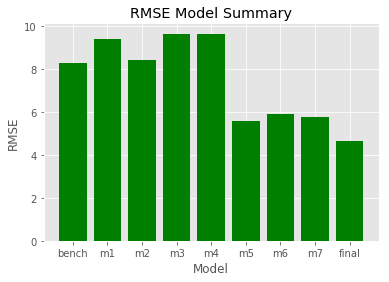

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['bench','m1', 'm2', 'm3', 'm4', 'm5', 'm6','m7', 'final']
RMSE = [8.29,9.431,8.408,9.657,9.657,5.588,5.906,5.759,4.653]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, RMSE, color='green')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Model Summary")

plt.xticks(x_pos, x)

plt.show()
plt.show()